In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import os
import re

train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')

print(f"train data (shape): {train_data.shape}")
print(f"validation data (shape): {valid_data.shape}")
print(f"test data (shape): {test_data.shape}")

train_data.head()


train data (shape): (10140, 79)
validation data (shape): (19156, 79)
test data (shape): (23540, 79)


,dialog_id,speaker,transcript,da_tag,start_time,end_time,function,pronoun,ppron,i,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,sw2005,B,SIL,x,0.00000,10.94882,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,sw2005,A,SIL,x,10.93013,21.35084,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,sw2005,B,well of course it's you know it's one of the l...,sv,10.94882,22.28000,0.642857,0.285714,0.190476,0.0,...,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0
3,sw2005,A,yes,b,21.35084,22.08088,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.0,0.000000,0.0
4,sw2005,A,SIL,x,22.08088,44.96288,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [6]:
print(list(train_data.columns))

['dialog_id', 'speaker', 'transcript', 'da_tag', 'start_time', 'end_time', 'function', 'pronoun', 'ppron', 'i', 'we', 'you', 'shehe', 'they', 'ipron', 'article', 'prep', 'auxverb', 'adverb', 'conj', 'negate', 'verb', 'adj', 'compare', 'interrog', 'number', 'quant', 'affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', 'social', 'family', 'friend', 'female', 'male', 'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', 'percept', 'see', 'hear', 'feel', 'bio', 'body', 'health', 'sexual', 'ingest', 'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', 'focuspast', 'focuspresent', 'focusfuture', 'relativ', 'motion', 'space', 'time', 'work', 'leisure', 'home', 'money', 'relig', 'death', 'informal', 'swear', 'netspeak', 'assent', 'nonflu', 'filler']


In [7]:
unique_da_tags = sorted(train_data['da_tag'].unique())

# list of dialogue act tags
print("List of dialogue act tags:", unique_da_tags)


List of dialogue act tags: ['%', 'aa', 'b', 'ba', 'fc', 'ny', 'qy', 'sd', 'sv', 'x']


In [8]:
# analyze da_tag == '%'
pct_rows = train_data[train_data['da_tag'] == '%']

pct_transcripts = pct_rows['transcript']

print("number of transcripts with da_tag '%':", len(pct_transcripts))
print(pct_transcripts.head(30))


number of transcripts with da_tag '%': 547
6                       uh our
14                 but there's
72                     i think
75            well my uh my uh
98                    and they
103                      so so
105                  i mean it
114                 well we we
154                     and um
174                   it would
178                      is it
196                  it wasn't
208                         uh
214                        but
228             i mean uh it's
289    it's uh hav- uh uh well
320                         um
323                         um
330                      right
343                       yeah
358                     but um
377                  just geez
394                         um
396                         um
400                         um
443                 i was just
527           so you know they
531                        but
538               you know th-
550                         so
Name: transcript, dtype: ob

In [9]:
print(train_data['transcript'])
print("\n row 2: ", train_data.iloc[2]['transcript'])


0                                                      SIL
1                                                      SIL
2        well of course it's you know it's one of the l...
3                                                      yes
4                                                      SIL
                               ...                        
10135             and they they don't offer any commentary
10136    and it gives me a quick chance to to be caught...
10137    so i don't like to go the whole day without he...
10138                                                  SIL
10139                                      oh i'm with you
Name: transcript, Length: 10140, dtype: object

 row 2:  well of course it's you know it's one of the last few things in the world you'd ever want to do you know unless it's just you know really you know and uh for their uh you know for their own good


# **EDA**

# Analyze Top LIWC features per da_tag

In [10]:
import pandas as pd

#liwc columns
exclude_cols = ['dialog_id', 'speaker', 'transcript', 'da_tag', 'start_time', 'end_time']
liwc_features = [col for col in train_data.columns if col not in exclude_cols]

# group by da_tag and get mean
liwc_means_by_tag = train_data.groupby('da_tag')[liwc_features].mean()

# top 10
top_features_by_tag = {}

for tag in liwc_means_by_tag.index:
    means = liwc_means_by_tag.loc[tag]
    top5 = means.sort_values(ascending=False).head(10)
    top_features_by_tag[tag] = top5

for tag, features in top_features_by_tag.items():
    print(f"\nda_tag: {tag}")
    print(features)



da_tag: %
function        0.648207
conj            0.269932
pronoun         0.254969
informal        0.238345
nonflu          0.158866
verb            0.151974
ppron           0.149052
adverb          0.147649
cogproc         0.129786
focuspresent    0.123971
Name: %, dtype: float64

da_tag: aa
informal        0.513872
assent          0.455804
function        0.263403
cogproc         0.144853
relativ         0.135609
space           0.132464
pronoun         0.111898
verb            0.109174
certain         0.104251
focuspresent    0.103964
Name: aa, dtype: float64

da_tag: b
informal    0.884092
assent      0.811253
relativ     0.080952
space       0.080686
nonflu      0.070444
affect      0.046688
posemo      0.045491
function    0.022027
cogproc     0.015908
netspeak    0.012769
Name: b, dtype: float64

da_tag: ba
function        0.365280
affect          0.291245
posemo          0.257595
pronoun         0.219942
informal        0.213080
nonflu          0.195148
focuspresent    0.156

# Analyze Average Word and Character Count per da_tag

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_word_count_per_da_tag(data):
    data['word_count'] = data['transcript'].apply(
        lambda x: len(str(x).split()) if pd.notna(x) else 0
    )

    word_count_by_da = data.groupby('da_tag')['word_count'].agg(
        ['count', 'mean', 'std', 'min', 'max']
    ).reset_index()

    word_count_by_da = word_count_by_da.sort_values('mean', ascending=False)

    print("average word count by da_tag:")
    for _, row in word_count_by_da.iterrows():
        print(f"{row['da_tag']}: {row['mean']:.2f} words (±{row['std']:.2f}), {row['count']} instances")

    #visualizations
    #bar plot
    plt.figure(figsize=(12, 8))

    x = np.arange(len(word_count_by_da))
    plt.bar(x, word_count_by_da['mean'], yerr=word_count_by_da['std'],
            capsize=5, alpha=0.7, color='steelblue')

    plt.xticks(x, word_count_by_da['da_tag'], rotation=90)

    plt.title('Average Word Count by Dialogue Act')
    plt.xlabel('Dialogue Act')
    plt.ylabel('Average Word Count')
    plt.tight_layout()
    plt.savefig('avg_word_count_by_da_with_std.png')

    return word_count_by_da

average word count by da_tag:
sv: 11.55 words (±8.78), 894 instances
sd: 10.99 words (±7.57), 2387 instances
qy: 8.15 words (±5.39), 153 instances
fc: 3.04 words (±2.61), 204 instances
ba: 2.72 words (±1.34), 158 instances
%: 2.38 words (±1.90), 547 instances
aa: 1.65 words (±1.41), 492 instances
ny: 1.11 words (±0.31), 100 instances
b: 1.07 words (±0.36), 1253 instances
x: 1.01 words (±0.53), 3952 instances


,da_tag,count,mean,std,min,max
8,sv,894,11.550336,8.778935,1,71
7,sd,2387,10.985756,7.566235,1,67
6,qy,153,8.150327,5.390991,1,34
4,fc,204,3.039216,2.605116,1,14
3,ba,158,2.721519,1.344360,1,9
0,%,547,2.380256,1.897997,1,14
1,aa,492,1.650407,1.409793,1,21
5,ny,100,1.110000,0.314466,1,2
2,b,1253,1.073424,0.363297,1,10
9,x,3952,1.008603,0.525172,1,34


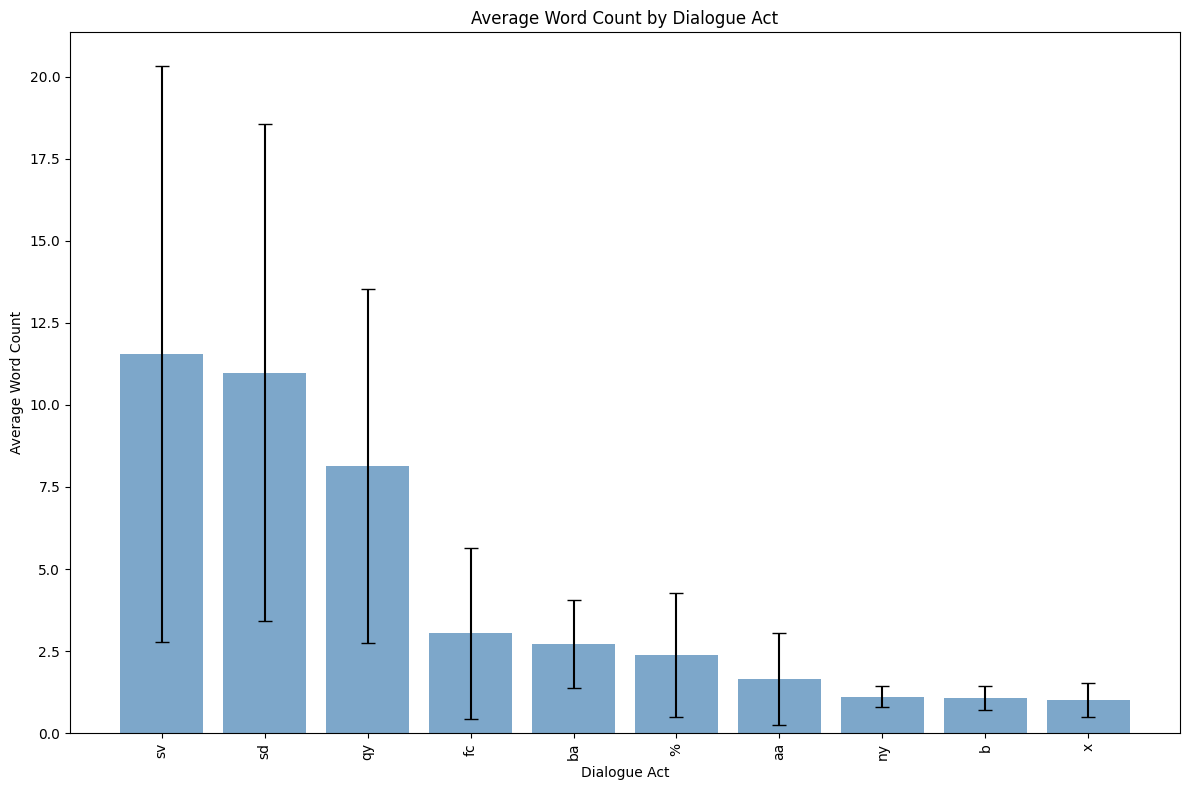

In [12]:
analyze_word_count_per_da_tag(train_data)

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_char_count_per_da_tag(data):
    data['char_count'] = data['transcript'].apply(
        lambda x: len(str(x)) if pd.notna(x) else 0
    )

    char_count_by_da = data.groupby('da_tag')['char_count'].agg(
        ['count', 'mean', 'std', 'min', 'max']
    ).reset_index()

    char_count_by_da = char_count_by_da.sort_values('mean', ascending=False)

    print("average character count by da_tag:")
    for _, row in char_count_by_da.iterrows():
        print(f"{row['da_tag']}: {row['mean']:.2f} characters (±{row['std']:.2f}), {row['count']} instances")

    #visualizations
    #bar plot
    plt.figure(figsize=(12, 8))

    x = np.arange(len(char_count_by_da))
    plt.bar(x, char_count_by_da['mean'], yerr=char_count_by_da['std'],
            capsize=5, alpha=0.7, color='steelblue')

    plt.xticks(x, char_count_by_da['da_tag'], rotation=90)

    plt.title('Average Character Count by Dialogue Act')
    plt.xlabel('Dialogue Act')
    plt.ylabel('Average Character Count')
    plt.tight_layout()
    plt.savefig('avg_char_count_by_da_with_std.png')

average character count by da_tag:
sv: 57.55 characters (±45.30), 894 instances
sd: 52.91 characters (±38.18), 2387 instances
qy: 38.69 characters (±27.95), 153 instances
fc: 14.21 characters (±13.14), 204 instances
ba: 12.47 characters (±7.33), 158 instances
%: 9.12 characters (±9.05), 547 instances
aa: 7.29 characters (±7.06), 492 instances
b: 4.91 characters (±1.73), 1253 instances
ny: 4.34 characters (±1.27), 100 instances
x: 3.52 characters (±3.23), 3952 instances


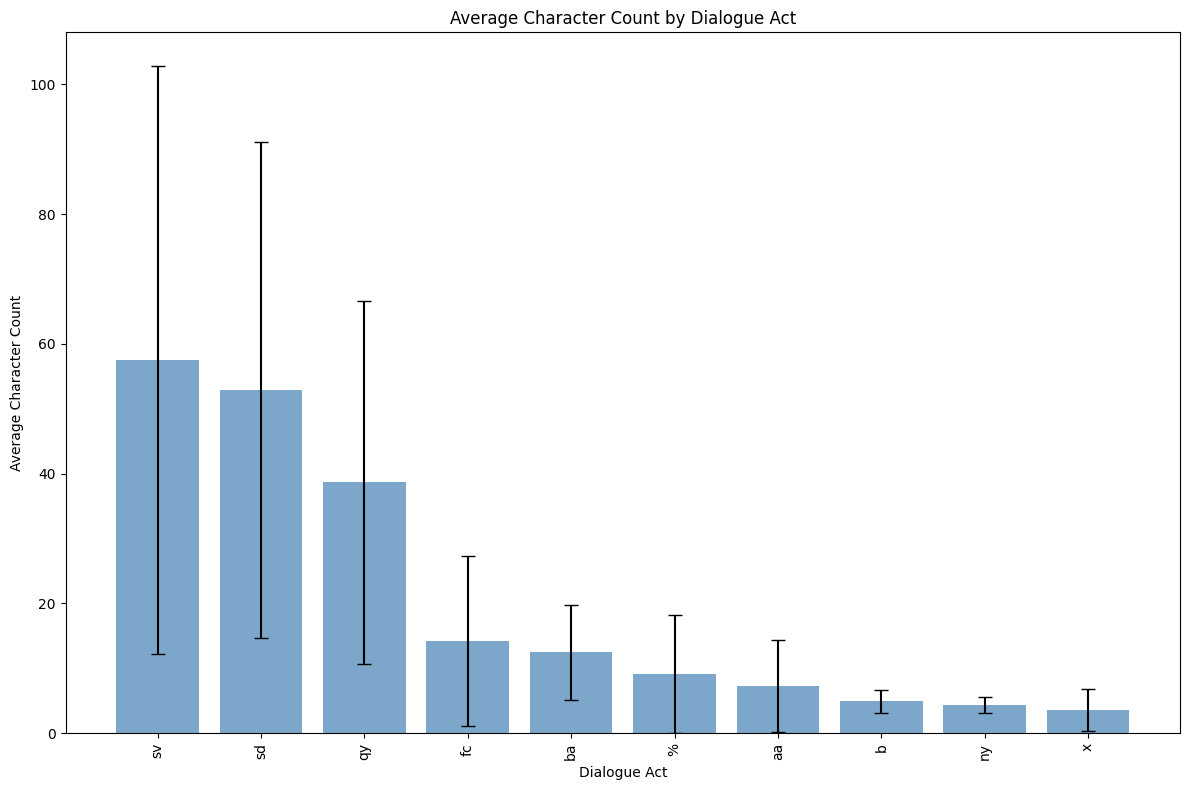

In [14]:
char_count_stats = analyze_char_count_per_da_tag(train_data)

# Analyze most common words per da_tag

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

def analyze_word_frequency_by_da_tag(data, top_n=10, remove_stopwords=True, min_word_length=2):

    stop_words = set(stopwords.words('english')) if remove_stopwords else set()


    da_word_frequencies = {}
    da_top_words = {}

    for da_tag, group in data.groupby('da_tag'):
        all_text = ' '.join(group['transcript'].fillna('').astype(str))

        tokens = re.findall(r'\b\w+\b', all_text.lower())

        filtered_tokens = [
            token for token in tokens
            if len(token) >= min_word_length and token not in stop_words
        ]

        # count word frequencies
        word_counts = Counter(filtered_tokens)

        top_words = word_counts.most_common(top_n)

        da_word_frequencies[da_tag] = word_counts
        da_top_words[da_tag] = top_words

    print(f"top 10 words for each da_tag:")

    for da_tag, top_words in da_top_words.items():
        print(f"\nda_tag: {da_tag}")
        for word, count in top_words:
            print(f"  {word}: {count}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
word_frequencies = analyze_word_frequency_by_da_tag(
    train_data,
    top_n=10,
    remove_stopwords=True,
    min_word_length=3
)

top 10 words for each da_tag:

da_tag: %
  know: 293
  yeah: 268
  well: 208
  mean: 88
  think: 79
  huh: 71
  like: 62
  really: 50
  okay: 27
  pause: 26

da_tag: aa
  yeah: 1091
  right: 606
  yes: 202
  true: 173
  huh: 129
  know: 111
  exactly: 103
  well: 69
  agree: 65
  sure: 63

da_tag: b
  huh: 3915
  yeah: 3754
  right: 1020
  okay: 210
  yes: 158
  sure: 95
  really: 72
  well: 51
  see: 45
  laughter: 26

da_tag: ba
  good: 139
  well: 118
  wow: 98
  great: 82
  gosh: 43
  nice: 43
  neat: 39
  interesting: 38
  sounds: 34
  goodness: 31

da_tag: fc
  bye: 231
  well: 99
  talking: 81
  okay: 62
  good: 58
  nice: 51
  yeah: 41
  enjoyed: 25
  right: 24
  talk: 23

da_tag: ny
  yeah: 499
  yes: 164
  huh: 99
  well: 14
  yep: 6
  yea: 2
  sir: 2
  mean: 2
  fixed: 1
  matter: 1

da_tag: qy
  like: 118
  well: 98
  know: 73
  think: 69
  ever: 68
  right: 45
  mean: 41
  work: 38
  huh: 35
  anything: 32

da_tag: sd
  know: 3076
  like: 1830
  well: 1107
  one: 1075
  re

### Top ngrams per da_tag

In [ ]:
import numpy as np
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=3000)
X = vectorizer.fit_transform(train_data['transcript'])
labels = train_data['da_tag']

label_ngrams = defaultdict(list)
for i, label in enumerate(labels):
    label_ngrams[label].append(X[i].toarray()[0])

label_means = {label: np.mean(label_ngrams[label], axis=0) for label in label_ngrams}

feature_names = vectorizer.get_feature_names_out()

In [ ]:
import pandas as pd

feature_names = vectorizer.get_feature_names_out()

for label, mean_vector in label_means.items():
    print(f"\ntop n-grams for da_tag: {label}")
    top_ngrams = sorted(zip(feature_names, mean_vector), key=lambda x: x[1], reverse=True)[:10]

    for ngram, score in top_ngrams:
        print(f"{ngram:20} -> {score:.4f}")



top n-grams for da_tag: x
sil                  -> 0.9261
laughter             -> 0.0551
noise                -> 0.0123
pause                -> 0.0043
yeah                 -> 0.0002
fixed                -> 0.0002
uh                   -> 0.0001
right                -> 0.0001
um                   -> 0.0001
uh huh               -> 0.0001

top n-grams for da_tag: sv
it                   -> 0.0613
that                 -> 0.0582
you                  -> 0.0511
and                  -> 0.0490
the                  -> 0.0488
to                   -> 0.0413
think                -> 0.0386
they                 -> 0.0351
of                   -> 0.0335
uh                   -> 0.0265

top n-grams for da_tag: b
yeah                 -> 0.3619
huh                  -> 0.2457
uh huh               -> 0.2345
uh                   -> 0.1872
right                -> 0.1011
oh                   -> 0.0521
okay                 -> 0.0192
yes                  -> 0.0154
oh yeah              -> 0.0125
sure               

### Analyze Exclamation mark and Question marks per da_tag

In [ ]:
def analyze_punctuation_by_da_tag(data):
    data['has_question_mark'] = data['transcript'].apply(lambda x: 1 if '?' in str(x) else 0)
    data['has_exclamation'] = data['transcript'].apply(lambda x: 1 if '!' in str(x) else 0)

    question_marks_by_da = data.groupby('da_tag')['has_question_mark'].agg(['count', 'sum', 'mean']).reset_index()
    exclamation_by_da = data.groupby('da_tag')['has_exclamation'].agg(['count', 'sum', 'mean']).reset_index()

    question_marks_by_da['percentage'] = question_marks_by_da['mean'] * 100
    exclamation_by_da['percentage'] = exclamation_by_da['mean'] * 100

    question_marks_by_da = question_marks_by_da.sort_values('percentage', ascending=False)
    exclamation_by_da = exclamation_by_da.sort_values('percentage', ascending=False)

    print("percentage of utterances with question marks by da_tag:")
    for _, row in question_marks_by_da.iterrows():
        print(f"{row['da_tag']}: {row['percentage']:.2f}% ({row['sum']} out of {row['count']} instances)")

    print("\npercentage of utterances with exclamation marks by da_tag:")
    for _, row in exclamation_by_da.iterrows():
        print(f"{row['da_tag']}: {row['percentage']:.2f}% ({row['sum']} out of {row['count']} instances)")

    import matplotlib.pyplot as plt

    # plot for question marks
    plt.figure(figsize=(12, 6))
    plt.bar(question_marks_by_da['da_tag'], question_marks_by_da['percentage'], color='skyblue')
    plt.title('Percentage of Utterances with Question Marks by Dialogue Act')
    plt.xlabel('Dialogue Act')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('question_marks_by_da.png')

    # plot for exclamation marks
    plt.figure(figsize=(12, 6))
    plt.bar(exclamation_by_da['da_tag'], exclamation_by_da['percentage'], color='salmon')
    plt.title('Percentage of Utterances with Exclamation Marks by Dialogue Act')
    plt.xlabel('Dialogue Act')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('exclamation_by_da.png')

    return question_marks_by_da, exclamation_by_da

percentage of utterances with question marks by da_tag:
qy: 0.08% (1 out of 1253 instances)
%: 0.00% (0 out of 4101 instances)
aa: 0.00% (0 out of 3136 instances)
b: 0.00% (0 out of 9925 instances)
fc: 0.00% (0 out of 638 instances)
ba: 0.00% (0 out of 1063 instances)
ny: 0.00% (0 out of 771 instances)
sd: 0.00% (0 out of 19149 instances)
sv: 0.00% (0 out of 7051 instances)
x: 0.00% (0 out of 27024 instances)

percentage of utterances with exclamation marks by da_tag:
ba: 1.22% (13 out of 1063 instances)
b: 0.01% (1 out of 9925 instances)
sd: 0.01% (1 out of 19149 instances)
%: 0.00% (0 out of 4101 instances)
aa: 0.00% (0 out of 3136 instances)
fc: 0.00% (0 out of 638 instances)
ny: 0.00% (0 out of 771 instances)
qy: 0.00% (0 out of 1253 instances)
sv: 0.00% (0 out of 7051 instances)
x: 0.00% (0 out of 27024 instances)


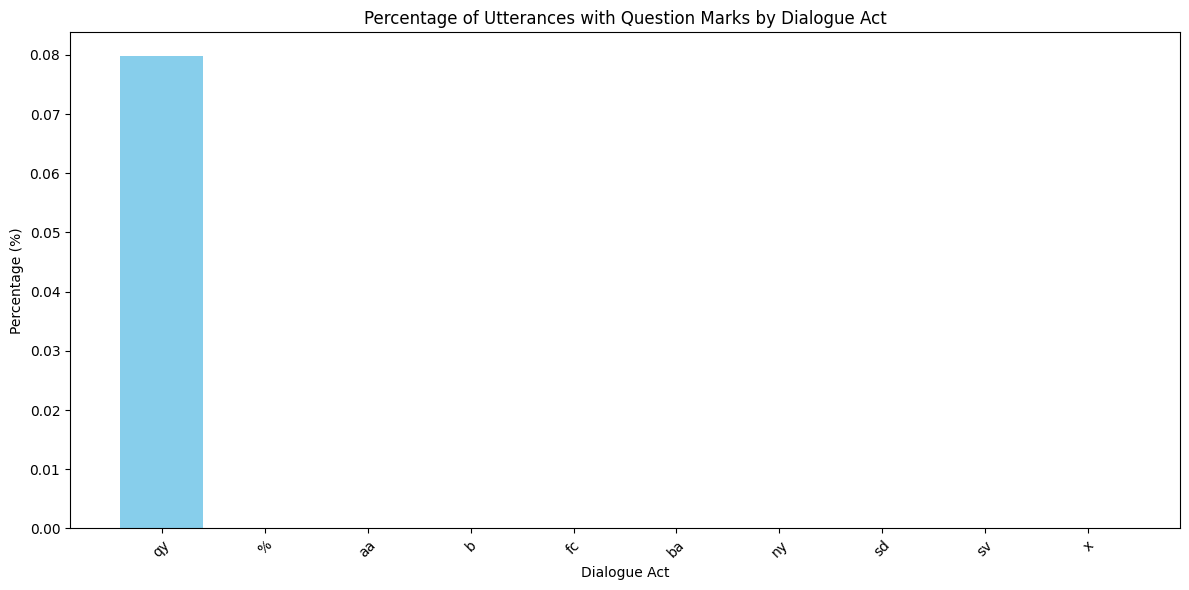

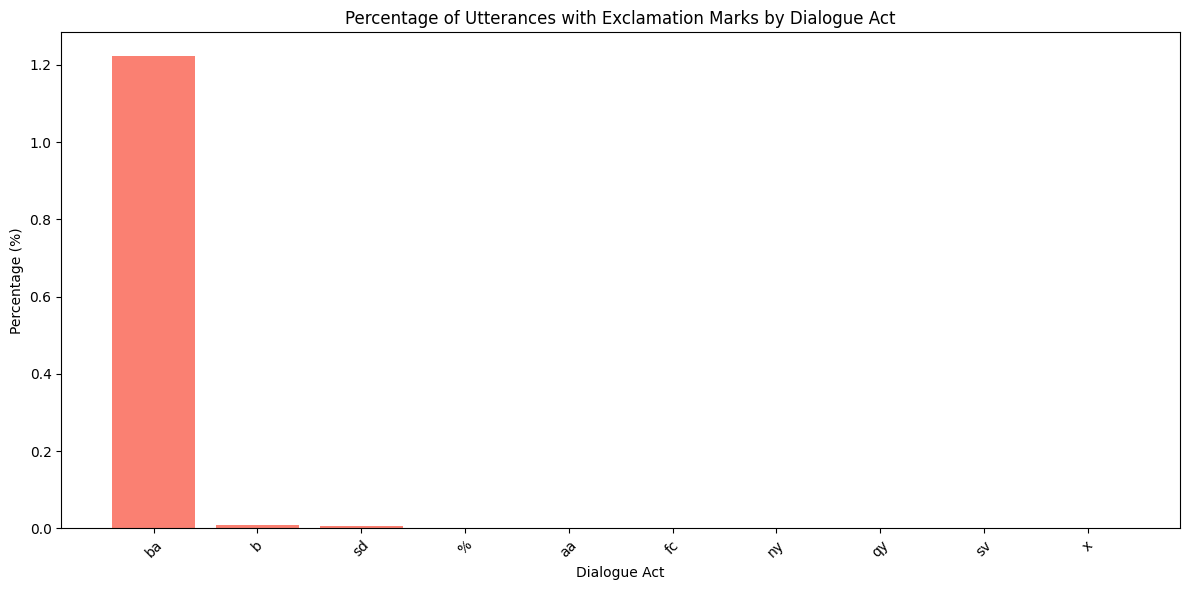

In [ ]:
question_stats, exclamation_stats = analyze_punctuation_by_da_tag(train_data)

### **1. Feature Extraction: Text based feature set**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import pickle
from collections import Counter
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

def text_features(data, dataset_type, embedding_model):
    # word count, character count, has question mark, has exclamation mark
    features_df = data.copy()
    features_df['word_count'] = features_df['transcript'].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
    features_df['char_count'] = features_df['transcript'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
    features_df['has_question_mark'] = features_df['transcript'].apply(lambda x: 1 if '?' in str(x) else 0)
    features_df['has_exclamation'] = features_df['transcript'].apply(lambda x: 1 if '!' in str(x) else 0)

    # sentence embedding of transcript
    print(f"[{dataset_type}] transcript sentence embeddings")
    transcripts = features_df['transcript'].fillna('').tolist()
    embeddings = embedding_model.encode(transcripts, show_progress_bar=True)
    embedding_df = pd.DataFrame(embeddings, columns=[f'embedding_{i}' for i in range(embeddings.shape[1])])

    # TF-IDF n-grams
    print(f"[{dataset_type}] TF-IDF n-grams")
    if dataset_type == 'train':
        tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=3000)
        tfidf_features = tfidf_vectorizer.fit_transform(features_df['transcript'].fillna(''))

        with open('tfidf_vectorizer.pkl', 'wb') as f:
            pickle.dump(tfidf_vectorizer, f)
    else:
        with open('tfidf_vectorizer.pkl', 'rb') as f:
            tfidf_vectorizer = pickle.load(f)
        tfidf_features = tfidf_vectorizer.transform(features_df['transcript'].fillna(''))

    tfidf_df = pd.DataFrame(
        tfidf_features.toarray(),
        columns=[f'tfidf_{feat}' for feat in tfidf_vectorizer.get_feature_names_out()]
    )

    # drop transcript column
    features_df.drop(columns=['transcript'], inplace=True)

    features_df = features_df.reset_index(drop=True)
    embedding_df = embedding_df.reset_index(drop=True)
    tfidf_df = tfidf_df.reset_index(drop=True)

    full_df = pd.concat([features_df, embedding_df, tfidf_df], axis=1)

    # metadata first then sentence embeddings then tfidf
    meta_cols = ['dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time']
    feature_cols = [col for col in full_df.columns if col not in meta_cols]
    full_df = full_df[meta_cols + feature_cols]

    return full_df


In [ ]:
print("extract text features for train data: ")
text_features_train = text_features(train_data, 'train', embedding_model)

print("extract text features for validation data: ")
text_features_valid = text_features(valid_data, 'valid', embedding_model)

print("extract text features for test data: ")
text_features_test = text_features(test_data, 'test', embedding_model)

# shape
print("\n")
print(f"train features shape:   {text_features_train.shape}")
print(f"validation features shape: {text_features_valid.shape}")
print(f"test features shape:       {text_features_test.shape}")

# show features
print("\ntraining text features:")
display(text_features_train.iloc[:, :10])
print("\nvalidation text features:")
display(text_features_valid.iloc[:, :10])
print("\ntest text features:")
display(text_features_test.iloc[:, :10])


# save features to csv

train_path = os.path.join("/content/drive/MyDrive/Colab Notebooks", "text_features_train.csv")
valid_path = os.path.join("/content/drive/MyDrive/Colab Notebooks", "text_features_valid.csv")
test_path  = os.path.join("/content/drive/MyDrive/Colab Notebooks", "text_features_test.csv")

text_features_train.to_csv(train_path, index=False)
text_features_valid.to_csv(valid_path, index=False)
text_features_test.to_csv(test_path,  index=False)


extract text features for train data: 
[train] transcript sentence embeddings


Batches:   0%|          | 0/2316 [00:00<?, ?it/s]

[train] TF-IDF n-grams
extract text features for validation data: 
[valid] transcript sentence embeddings


Batches:   0%|          | 0/599 [00:00<?, ?it/s]

[valid] TF-IDF n-grams
extract text features for test data: 
[test] transcript sentence embeddings


Batches:   0%|          | 0/736 [00:00<?, ?it/s]

[test] TF-IDF n-grams


train features shape:   (74111, 3850)
validation features shape: (19156, 3850)
test features shape:       (23540, 3850)

training text features:


,dialog_id,speaker,da_tag,start_time,end_time,function,pronoun,ppron,i,we
0,sw2005,B,x,0.00000,10.94882,0.000000,0.000000,0.000000,0.0,0.000
1,sw2005,A,x,10.93013,21.35084,0.000000,0.000000,0.000000,0.0,0.000
2,sw2005,B,sv,10.94882,22.28000,0.642857,0.285714,0.190476,0.0,0.000
3,sw2005,A,b,21.35084,22.08088,0.000000,0.000000,0.000000,0.0,0.000
4,sw2005,A,x,22.08088,44.96288,0.000000,0.000000,0.000000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...
74106,sw4940,A,ny,294.59659,295.00000,0.000000,0.000000,0.000000,0.0,0.000
74107,sw4940,B,sd,294.62349,297.66445,0.375000,0.250000,0.125000,0.0,0.000
74108,sw4940,A,x,295.00000,298.58336,0.000000,0.000000,0.000000,0.0,0.000
74109,sw4940,B,x,297.66445,299.88000,0.000000,0.000000,0.000000,0.0,0.000



validation text features:


,dialog_id,speaker,da_tag,start_time,end_time,function,pronoun,ppron,i,we
0,sw2025,B,x,0.00000,1.91195,0.0,0.000,0.000,0.0,0.000
1,sw2025,A,x,1.87913,2.70028,0.0,0.000,0.000,0.0,0.000
2,sw2025,A,%,2.70028,2.92781,0.0,0.000,0.000,0.0,0.000
3,sw2025,A,b,2.92781,3.61040,0.0,0.000,0.000,0.0,0.000
4,sw2025,B,x,3.20215,5.13744,0.0,0.000,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...
19151,sw4902,A,x,295.62720,297.56000,0.0,0.000,0.000,0.0,0.000
19152,sw4902,B,sv,295.68000,297.38242,0.5,0.125,0.125,0.0,0.125
19153,sw4902,B,x,297.38242,298.56000,0.0,0.000,0.000,0.0,0.000
19154,sw4902,A,b,297.56000,297.84071,0.0,0.000,0.000,0.0,0.000



test text features:


,dialog_id,speaker,da_tag,start_time,end_time,function,pronoun,ppron,i,we
0,sw2019,A,NaN,0.00000,2.92922,0.000000,0.000000,0.000000,0.0,0.0
1,sw2019,B,NaN,0.00000,4.46754,0.000000,0.000000,0.000000,0.0,0.0
2,sw2019,A,NaN,2.92922,4.31867,0.571429,0.142857,0.142857,0.0,0.0
3,sw2019,A,NaN,4.31867,6.74838,0.000000,0.000000,0.000000,0.0,0.0
4,sw2019,B,NaN,4.46754,5.01339,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
23535,sw4936,B,NaN,294.02342,294.43437,0.000000,0.000000,0.000000,0.0,0.0
23536,sw4936,B,NaN,294.43437,297.07133,0.000000,0.000000,0.000000,0.0,0.0
23537,sw4936,A,NaN,296.74224,299.04000,0.000000,0.000000,0.000000,0.0,0.0
23538,sw4936,B,NaN,297.07133,297.19119,0.000000,0.000000,0.000000,0.0,0.0


### **2. Feature Analysis - Text based feature set**

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score
# tags to analyze (informative, acknolwedgement )
informative_acts   = ['sv', 'sd']
acknowledgment_acts = ['b', 'aa']


BASE_DIR   = "/content/drive/MyDrive/Colab Notebooks"
train_path = os.path.join(BASE_DIR, "text_features_train.csv")
valid_path = os.path.join(BASE_DIR, "text_features_valid.csv")
test_path  = os.path.join(BASE_DIR, "text_features_test.csv")

text_features_train  = pd.read_csv(train_path)

informative_acts    = ['sv', 'sd']
acknowledgment_acts = ['b', 'aa']

df = text_features_train.copy()
df['act_category'] = np.where(
    df['da_tag'].isin(informative_acts),   'Informative',
    np.where(df['da_tag'].isin(acknowledgment_acts), 'Acknowledgment', 'Other')
)


# stats
print(df.groupby('act_category')['word_count']
      .agg(['mean', 'median', 'std', 'count'])
      .loc[['Informative', 'Acknowledgment']])

# Mann‑Whitney U test
inf_wc  = df.loc[df['act_category'] == 'Informative',   'word_count']
ack_wc  = df.loc[df['act_category'] == 'Acknowledgment','word_count']
U, p    = stats.mannwhitneyu(inf_wc, ack_wc)
print(f"Mann‑Whitney U: {U},  p‑value: {p:.3e}")

# Effect size (Cohen’s d)
pooled_std = np.sqrt(
    ((len(inf_wc)-1)*inf_wc.std(ddof=1)**2 + (len(ack_wc)-1)*ack_wc.std(ddof=1)**2)
    / (len(inf_wc) + len(ack_wc) - 2)
)
d = (inf_wc.mean() - ack_wc.mean()) / pooled_std
print(f"Cohen’s d: {d:.2f}")

# 5 word threshold classifier
threshold = 5
mask      = df['act_category'].isin(['Informative', 'Acknowledgment'])
y_true    = df.loc[mask, 'act_category']
y_pred    = np.where(df.loc[mask, 'word_count'] >= threshold, 'Informative', 'Acknowledgment')
acc       = accuracy_score(y_true, y_pred)
print(f"Length‑threshold accuracy (≥{threshold} words): {acc:.4f}")


                     mean  median       std  count
act_category                                      
Informative     10.904656     9.0  7.478620  26200
Acknowledgment   1.228773     1.0  0.856934  13061
Mann‑Whitney U: 336073032.5,  p‑value: 0.000e+00
Cohen’s d: 1.58
Length‑threshold accuracy (≥5 words): 0.8959


In [ ]:
import pandas as pd, numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import mannwhitneyu

df = pd.read_csv("train.csv")

non_liwc = [
    "dialog_id", "speaker", "transcript", "da_tag",
    "start_time", "end_time", "split"
]
liwc_cols = [c for c in df.columns if c not in non_liwc]

backchannel_tags = ["b", "aa", "ny"]
informative_tags = ["sd", "sv"]
liwc_focus       = ["informal", "assent", "function", "verb"]

print("Mean proportion per LIWC: ")
print("Backchannels (b, aa, ny):")
print(df[df.da_tag.isin(backchannel_tags)][liwc_focus].mean().round(3))
print("\nInformatives (sd, sv):")
print(df[df.da_tag.isin(informative_tags)][liwc_focus].mean().round(3))

# Mann Whitney U test, effect size

def cohens_d(a, b):
    return (a.mean() - b.mean()) / np.sqrt(((a.var(ddof=1) + b.var(ddof=1)) / 2))

print("\nsignificance test (back‑channels vs. informatives)")
for feat in liwc_focus:
    bc_vals = df.loc[df.da_tag.isin(backchannel_tags), feat]
    inf_vals = df.loc[df.da_tag.isin(informative_tags), feat]
    U, p = mannwhitneyu(bc_vals, inf_vals, alternative="two-sided")
    d = cohens_d(bc_vals, inf_vals)
    print(f"{feat:<9s}  U={U:,.0f}  p={p:.3e}  d={d:.2f}")



Mean proportion per LIWC: 
Backchannels (b, aa, ny):
informal    0.784
assent      0.710
function    0.073
verb        0.028
dtype: float64

Informatives (sd, sv):
informal    0.038
assent      0.002
function    0.621
verb        0.234
dtype: float64

significance test (back‑channels vs. informatives)
informal   U=316,013,506  p=0.000e+00  d=2.56
assent     U=314,516,478  p=0.000e+00  d=2.28
function   U=21,204,818  p=0.000e+00  d=-2.83
verb       U=36,591,368  p=0.000e+00  d=-1.61


### Speech-based Features

In [ ]:
import parselmouth
from parselmouth.praat import call
import glob
import os
import csv
import pandas as pd
import os.path as path


In [ ]:
pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 80.6 MB/s eta 0:00:00


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/wav/

/content/drive/MyDrive/Colab Notebooks/wav


In [ ]:
import os
import os.path as path
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import parselmouth
from parselmouth.praat import call
import numpy as np

MIN_DURATION = 0.064

# ensure at least 64ms
def ensure_min_duration(df, min_duration=MIN_DURATION):
    df = df.copy()
    df["duration"] = df["end_time"] - df["start_time"]
    too_short = df["duration"] < min_duration
    df.loc[too_short, "end_time"] = df.loc[too_short, "start_time"] + min_duration
    return df

# extract segment using parselmouth
def extract_segment(filepath, start_time, end_time, min_duration=MIN_DURATION):
    try:
        if end_time - start_time < min_duration:
            end_time = start_time + min_duration

        full_sound = parselmouth.Sound(filepath)
        max_time = full_sound.get_total_duration()
        end_time = min(end_time, max_time)

        return full_sound.extract_part(from_time=start_time, to_time=end_time)
    except Exception as e:
        print(f"Error extracting segment: {e}")
        return None


In [ ]:

#extract features
def extract_features(sound):
    feature_dict = {
        "Pitch_Min": np.nan,
        "Pitch_Max": np.nan,
        "Pitch_Mean": np.nan,
        "Pitch_SD": np.nan,
        "Intensity_Min": np.nan,
        "Intensity_Max": np.nan,
        "Intensity_Mean": np.nan,
        "Intensity_SD": np.nan,
        "Jitter": np.nan,
        "Shimmer": np.nan,
        "HNR": np.nan
    }

    # pitch
    try:
        pitch = call(sound, "To Pitch", 0.0, 75, 600)
        feature_dict["Pitch_Min"] = call(pitch, "Get minimum", 0, 0, "Hertz", "Parabolic")
        feature_dict["Pitch_Max"] = call(pitch, "Get maximum", 0, 0, "Hertz", "Parabolic")
        feature_dict["Pitch_Mean"] = call(pitch, "Get mean", 0, 0, "Hertz")
        feature_dict["Pitch_SD"] = call(pitch, "Get standard deviation", 0, 0, "Hertz")
    except Exception as e:
        print(f"Pitch error: {e}")

    # intensity
    try:
        intensity = call(sound, "To Intensity", 100, 0, 600)
        feature_dict["Intensity_Min"] = call(intensity, "Get minimum", 0, 0, "Parabolic")
        feature_dict["Intensity_Max"] = call(intensity, "Get maximum", 0, 0, "Parabolic")
        feature_dict["Intensity_Mean"] = call(intensity, "Get mean", 0, 0, "energy")
        feature_dict["Intensity_SD"] = call(intensity, "Get standard deviation", 0, 0)
    except Exception as e:
        print(f"Intensity error: {e}")

    # jitter/shimmer
    try:
        point_process = call(sound, "To PointProcess (periodic, cc)", 75.0, 600.0)
        feature_dict["Jitter"] = call(point_process, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3)
        feature_dict["Shimmer"] = call([sound, point_process], "Get shimmer (local)", 0.0, 0.0, 0.0001, 0.02, 1.3, 1.6)
    except Exception as e:
        print(f"Jitter/Shimmer error: {e}")

    # hnr
    try:
        harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75.0, 0.1, 1.0)
        feature_dict["HNR"] = call(harmonicity, "Get mean", 0.0, 0.0)
    except Exception as e:
        print(f"HNR error: {e}")

    return feature_dict


In [ ]:
def process_row(row):
    base_path = "/content/drive/MyDrive/Colab Notebooks/wav/"

    dialog_id = row["dialog_id"]
    da_tag = row["da_tag"]
    split = row.get("split", "")
    speaker = row["speaker"]
    start_time = row.get("start_time", 0)
    end_time = row.get("end_time", 0)

    filename = f"{dialog_id}_{speaker}.wav"
    filepath = path.join(base_path, filename)

    if path.exists(filepath):
        sound = extract_segment(filepath, start_time, end_time)
        if sound:
            features = extract_features(sound)
            if features:
                features.update({
                    "dialog_id": dialog_id,
                    "speaker": speaker,
                    "da_tag": da_tag,
                    "start_time": start_time,
                    "end_time": end_time,
                    "split": split
                })
                return features
    else:
        print(f"File not found: {filepath}")
    return None


In [ ]:
splits = ["train", "valid", "test"]

for split in splits:
    print(f"Processing {split} split...")
    output_path = "/content/drive/MyDrive/Colab Notebooks/"
    df = pd.read_csv(f"{output_path}{split}.csv")

    if "split" not in df.columns:
        df["split"] = split

    df = ensure_min_duration(df)
    rows = df.to_dict("records")

    with Pool(processes=cpu_count()) as pool:
        split_results = []
        save_every = 1000
        for i, result in enumerate(tqdm(pool.imap_unordered(process_row, rows), total=len(rows))):
            if result:
                split_results.append(result)
            if i > 0 and i % save_every == 0:
                pd.DataFrame(split_results).to_csv(f"{output_path}{split}_speech_features_partial_{i}.csv", index=False)

    split_df = pd.DataFrame(split_results)
    print(f"Shape of resulting DataFrame: {split_df.shape}")
    split_df.to_csv(f"{output_path}{split}_speech_features.csv", index=False)
    print(f"Saved {len(split_df)} rows of speech features for {split} split")
    print(f"First few columns: {split_df.columns[:10].tolist()}")


Processing train split...


 47%|████▋     | 34979/74111 [22:30<21:18, 30.60it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.0485 s.
Sound "untitled": intensity analysis not performed.



 86%|████████▋ | 63960/74111 [37:52<05:11, 32.54it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.042 s.
Sound "untitled": intensity analysis not performed.



100%|██████████| 74111/74111 [43:01<00:00, 28.71it/s]


Shape of resulting DataFrame: (74111, 18)
Saved 74111 rows of speech features for train split
First few columns: ['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer']
Processing valid split...


 30%|███       | 5778/19156 [03:45<13:34, 16.42it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.06325 s.
Sound "untitled": intensity analysis not performed.



100%|██████████| 19156/19156 [11:03<00:00, 28.89it/s]


Shape of resulting DataFrame: (19156, 18)
Saved 19156 rows of speech features for valid split
First few columns: ['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer']
Processing test split...


 67%|██████▋   | 15842/23540 [09:23<02:54, 44.16it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.058 s.
Sound "untitled": intensity analysis not performed.



 72%|███████▏  | 16863/23540 [09:53<03:41, 30.12it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.042 s.
Sound "untitled": intensity analysis not performed.



 73%|███████▎  | 17131/23540 [10:03<03:16, 32.68it/s]

Intensity error: Sound "untitled": shorter than window length.
The physical duration of the sound (the number of samples times the sampling period) in an intensity analysis should be at least 6.4 divided by the minimum pitch (100 Hz), i.e. at least 0.064 s, instead of 0.058 s.
Sound "untitled": intensity analysis not performed.



100%|██████████| 23540/23540 [13:21<00:00, 29.37it/s]


Shape of resulting DataFrame: (23540, 18)
Saved 23540 rows of speech features for test split
First few columns: ['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer']


In [ ]:
!ls -lh "/content/drive/MyDrive/Colab Notebooks/" | grep "speech_features"


-rw------- 1 root root  5.6M Apr 15 06:01 test_speech_features.csv
-rw------- 1 root root  2.4M Apr 15 05:54 test_speech_features_partial_10000.csv
-rw------- 1 root root  247K Apr 15 05:48 test_speech_features_partial_1000.csv
-rw------- 1 root root  2.7M Apr 15 05:54 test_speech_features_partial_11000.csv
-rw------- 1 root root  2.9M Apr 15 05:55 test_speech_features_partial_12000.csv
-rw------- 1 root root  3.2M Apr 15 05:55 test_speech_features_partial_13000.csv
-rw------- 1 root root  3.4M Apr 15 05:56 test_speech_features_partial_14000.csv
-rw------- 1 root root  3.6M Apr 15 05:56 test_speech_features_partial_15000.csv
-rw------- 1 root root  3.9M Apr 15 05:57 test_speech_features_partial_16000.csv
-rw------- 1 root root  4.1M Apr 15 05:57 test_speech_features_partial_17000.csv
-rw------- 1 root root  4.4M Apr 15 05:58 test_speech_features_partial_18000.csv
-rw------- 1 root root  4.6M Apr 15 05:58 test_speech_features_partial_19000.csv
-rw------- 1 root root  4.8M Apr 15 05:59 t

In [5]:
# calculate speech rate

def calculate_syllable_rate(df):
    df_with_rate = df.copy()

    # calculate utterance duration
    df_with_rate['duration'] = df_with_rate['end_time'] - df_with_rate['start_time']
    df_with_rate['syllable_count'] = 0

    # estimate syllables based on intensity
    voiced_mask = ~df_with_rate['Pitch_Mean'].isna()

    # use intensity variation to estimate syllable count
    for idx, row in df_with_rate[voiced_mask].iterrows():
        base_count = max(1, round(row['duration'] / 0.225))

        if not np.isnan(row['Intensity_SD']) and row['Intensity_SD'] > 0:

            intensity_factor = row['Intensity_SD'] / 5.0
            intensity_factor = min(2.0, max(0.5, intensity_factor))

            syllable_count = round(base_count * intensity_factor)

            syllable_count = max(1, syllable_count)
        else:
            syllable_count = base_count

        df_with_rate.at[idx, 'syllable_count'] = syllable_count

    # duration based fallback
    unvoiced_mask = ~voiced_mask
    # 1 syllable per 300ms for unvoiced segments
    df_with_rate.loc[unvoiced_mask, 'syllable_count'] = np.maximum(
        1, np.round(df_with_rate.loc[unvoiced_mask, 'duration'] / 0.3)
    )

    # Calculate speaking rate as syllables per second
    df_with_rate['Speaking_Rate'] = df_with_rate['syllable_count'] / df_with_rate['duration']

    # handle extreme values
    df_with_rate['Speaking_Rate'] = df_with_rate['Speaking_Rate'].clip(1.0, 8.0)

    df_with_rate = df_with_rate.drop(['duration', 'syllable_count'], axis=1)

    return df_with_rate

# apply to each split
splits = ["train", "valid", "test"]
base_path = "/content/drive/MyDrive/Colab Notebooks/"

for split in splits:
    file_path = f"{base_path}{split}_speech_features.csv"

    df = pd.read_csv(file_path)

    # calculate speaking rate
    df_with_rate = calculate_syllable_rate(df)

    df_with_rate.to_csv(file_path, index=False)

    print(f"Processed {split} split: {len(df_with_rate)} utterances")
    print(f"Average speaking rate: {df_with_rate['Speaking_Rate'].mean():.2f} syllables/second")

Processed train split: 74111 utterances
Average speaking rate: 6.68 syllables/second
Processed valid split: 19156 utterances
Average speaking rate: 6.65 syllables/second
Processed test split: 23540 utterances
Average speaking rate: 6.70 syllables/second


In [7]:
import pandas as pd

splits = ["train", "valid", "test"]
base_path = "/content/drive/MyDrive/Colab Notebooks/"

for split in splits:
    file_path = f"{base_path}{split}_speech_features.csv"
    print(f"\n{split.upper()} split:")

    df = pd.read_csv(file_path)

    # shape
    print(f"shape of {split} set: {df.shape}")  # (rows, columns)

    # list of columns
    print(f"columns in {split} set:")
    print(df.columns.tolist())

    # first 10 rows
    print(f"\nfirst 10 rows of {split} set:")
    print(df.head(10))




TRAIN split:
shape of train set: (74111, 18)
columns in train set:
['Pitch_Min', 'Pitch_Max', 'Pitch_Mean', 'Pitch_SD', 'Intensity_Min', 'Intensity_Max', 'Intensity_Mean', 'Intensity_SD', 'Jitter', 'Shimmer', 'HNR', 'dialog_id', 'speaker', 'da_tag', 'start_time', 'end_time', 'split', 'Speaking_Rate']

first 10 rows of train set:
    Pitch_Min   Pitch_Max  Pitch_Mean   Pitch_SD  Intensity_Min  \
0   98.272004  132.748855  107.849507   7.938820      17.841690   
1   85.344637   98.095258   91.918411   2.448362      19.384765   
2   79.393979  129.127258  102.582369  15.313113      14.665740   
3   74.692568  125.885080   99.452758  13.524605      13.158364   
4   76.595613  579.072883  112.604750  80.076506      17.813365   
5   87.138127  172.838418  116.408650  17.341471      13.044169   
6   76.264618  581.627307  119.113669  92.760917      13.812498   
7   75.941648  563.316764  114.449715  93.560777      14.120150   
8   75.668863  464.074593  104.577436  48.937568      12.710103  

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_speech_features.csv")

# speech columns
speech_features = [
    "Pitch_Min", "Pitch_Max", "Pitch_Mean", "Pitch_SD",
    "Intensity_Min", "Intensity_Max", "Intensity_Mean", "Intensity_SD",
    "Jitter", "Shimmer", "HNR"
]

# group by da_tag, compute mean
summary_df = df.groupby("da_tag")[speech_features].mean().reset_index()

summary_df.rename(columns={"da_tag": "Target"}, inplace=True)

# top 10 rows
print(summary_df.head(10))



  Target   Pitch_Min   Pitch_Max  Pitch_Mean   Pitch_SD  Intensity_Min  \
0      %  125.405876  259.388189  171.521529  39.036923      23.549652   
1     aa  129.767278  246.476862  174.966071  34.241899      30.366981   
2      b  132.154998  222.524179  169.239767  26.752639      25.879267   
3     ba  124.833289  287.562603  189.812862  45.270613      22.080983   
4     fc  142.917937  305.802663  206.192665  43.673860      15.163283   
5     ny  142.040714  243.479893  183.007483  32.256095      30.430901   
6     qy  123.094589  318.205260  180.256461  39.148146      20.202755   
7     sd  105.472716  332.658659  166.829717  44.543544      19.333197   
8     sv  102.481875  351.008955  164.807539  48.241556      17.738389   
9      x  133.454209  329.262297  197.355964  46.721437     -12.269999   

   Intensity_Max  Intensity_Mean  Intensity_SD    Jitter   Shimmer        HNR  
0      65.757561       58.966885     12.270656  0.023395  0.112342   9.000219  
1      66.628286       60

# speech analysis

In [ ]:
import pandas as pd, numpy as np, scipy.stats as st, matplotlib.pyplot as plt, seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_speech_features.csv")

speech_cols = [
    'Pitch_Min','Pitch_Max','Pitch_Mean','Pitch_SD',
    'Intensity_Min','Intensity_Max','Intensity_Mean','Intensity_SD',
    'Jitter','Shimmer','HNR','Speaking_Rate'
]

# print means, Mann Whitney U and cohen's d
def mw_report(series1, series2, name1, name2, feat):
    u, p = st.mannwhitneyu(series1, series2, alternative="two-sided")
    d = (series1.mean() - series2.mean()) / np.sqrt(
        ((series1.var(ddof=1) + series2.var(ddof=1)) / 2)
    )
    print(f"{feat:<15s} {name1:>10s} μ={series1.mean():.2f}  |  "
          f"{name2:>10s} μ={series2.mean():.2f}  |  U={u:,.0f}  p={p:.3e}  d={d:.2f}")


qy = df[df.da_tag == "qy"]
stmt = df[df.da_tag.isin(["sd", "sv"])]

print("\nPitch in qy vs statements (sd, sv)")
for feat in ["Pitch_Max", "Pitch_Mean"]:
    mw_report(qy[feat].dropna(), stmt[feat].dropna(), "qy", "stmt", feat)


ba  = df[df.da_tag == "ba"]
back = df[df.da_tag.isin(["b", "aa"])]

print("\nIntensity in ba vs back‑channels")
for feat in ["Intensity_Max", "Intensity_Mean"]:
    mw_report(ba[feat].dropna(), back[feat].dropna(), "ba", "b+aa", feat)


inform = df[df.da_tag.isin(["sv", "sd"])]
feedback = df[df.da_tag.isin(["b", "x"])]

print("\nSpeaking rate informative (sv, sd) backchannel (b, x)")
mw_report(inform["Speaking_Rate"].dropna(),
          feedback["Speaking_Rate"].dropna(),
          "sv+sd", "b+x", "Speaking_Rate")


focus_tags = ["fc", "x", "sd", "b"]

summary = (
    df[df["da_tag"].isin(focus_tags)]
      .groupby("da_tag")["Pitch_Mean"]
      .agg(mean="mean", sd="std", n="count")
      .round({"mean": 1, "sd": 1})
      .reset_index()
)

summary = (
    df[df["da_tag"].isin(focus_tags)]
      .groupby("da_tag")["Pitch_Mean"]
      .agg(mean="mean", sd="std", n="count")
      .round({"mean": 1, "sd": 1})
      .reset_index()
)

print(summary)

# fc vs sd
from scipy.stats import mannwhitneyu

fc_pitch = df.loc[df.da_tag == "fc", "Pitch_Mean"].dropna()
sd_pitch = df.loc[df.da_tag == "sd", "Pitch_Mean"].dropna()

U, p = mannwhitneyu(fc_pitch, sd_pitch, alternative="two-sided")
print(f"\nMann Whitney U test (fc vs sd): U={U:,.0f}, p={p:.3e}")



Pitch in qy vs statements (sd, sv)
Pitch_Max               qy μ=318.21  |        stmt μ=337.60  |  U=15,456,814  p=1.299e-03  d=-0.13
Pitch_Mean              qy μ=180.26  |        stmt μ=166.29  |  U=18,837,546  p=4.961e-20  d=0.26

Intensity in ba vs back‑channels
Intensity_Max           ba μ=65.95  |        b+aa μ=63.62  |  U=8,075,216  p=7.320e-19  d=0.28
Intensity_Mean          ba μ=59.07  |        b+aa μ=58.12  |  U=7,398,398  p=3.500e-04  d=0.11

Speaking rate informative (sv, sd) backchannel (b, x)
Speaking_Rate        sv+sd μ=3.70  |         b+x μ=1.17  |  U=907,432,394  p=0.000e+00  d=1.67
  da_tag   mean    sd      n
0      b  169.2  58.6   9812
1     fc  206.2  73.1    633
2     sd  166.8  52.0  19099
3      x  197.4  88.7  22023

Mann Whitney U test (fc vs sd): U=8,048,341, p=8.003e-46
